In [2]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.sparse as sp

## Parameters

In [3]:
horizon = 480 #5 days, 15-min intervals

In [4]:
# Create a model: Automatic Demand Response (ADR)
model = gp.Model("ADR") 

Set parameter Username
Set parameter LicenseID to value 2648244
Academic license - for non-commercial use only - expires 2026-04-07


## Data Loading

### Electricity demand

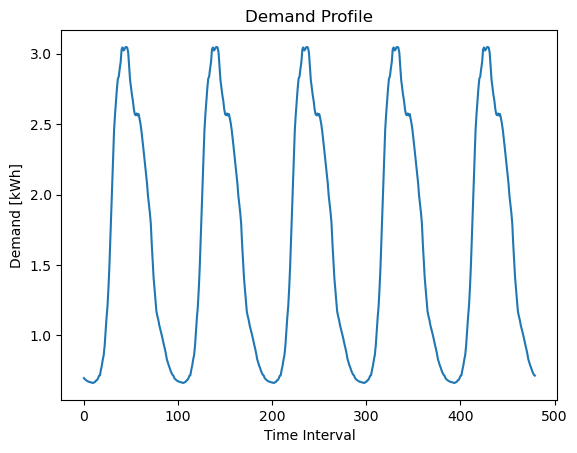

In [5]:
profile_demand = pd.read_csv('Demand_Data_15min.csv', sep=',', decimal='.')
facteur = 50000/1000000
real_Demand= profile_demand['Demand']*facteur
Critical_Demand= np.array(real_Demand)

#plot the Demand Column
plt.plot(real_Demand)
plt.title('Demand Profile')
plt.xlabel('Time Interval')
plt.ylabel('Demand [kWh]')
plt.show()


### Electricity price loading

2024-04-07 00:00:00,19.94
2024-04-07 00:15:00,19.94
2024-04-07 00:30:00,19.94
2024-04-07 00:45:00,19.94
2024-04-07 01:00:00,19.94
2024-04-07 01:15:00,19.94
2024-04-07 01:30:00,19.94
2024-04-07 01:45:00,19.94
2024-04-07 02:00:00,19.94
2024-04-07 02:15:00,19.94
2024-04-07 02:30:00,19.94
2024-04-07 02:45:00,19.94
2024-04-07 03:00:00,19.94
2024-04-07 03:15:00,19.94
2024-04-07 03:30:00,19.94
2024-04-07 03:45:00,19.94
2024-04-07 04:00:00,19.94
2024-04-07 04:15:00,19.94
2024-04-07 04:30:00,19.94
2024-04-07 04:45:00,19.94
2024-04-07 05:00:00,19.94
2024-04-07 05:15:00,19.94
2024-04-07 05:30:00,19.94
2024-04-07 05:45:00,19.94
2024-04-07 06:00:00,31.73
2024-04-07 06:15:00,31.73
2024-04-07 06:30:00,31.73
2024-04-07 06:45:00,31.73
2024-04-07 07:00:00,31.73
2024-04-07 07:15:00,31.73
2024-04-07 07:30:00,31.73
2024-04-07 07:45:00,31.73
2024-04-07 08:00:00,31.73
2024-04-07 08:15:00,31.73
2024-04-07 08:30:00,31.73
2024-04-07 08:45:00,31.73
2024-04-07 09:00:00,31.73
2024-04-07 09:15:00,31.73
2024-04-07 0

/var/folders/0w/44rywk3j1dl_gqy839v3wqyh0000gn/T/ipykernel_32863/1188190650.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rng = pd.date_range(start, periods=horizon, freq='15T')


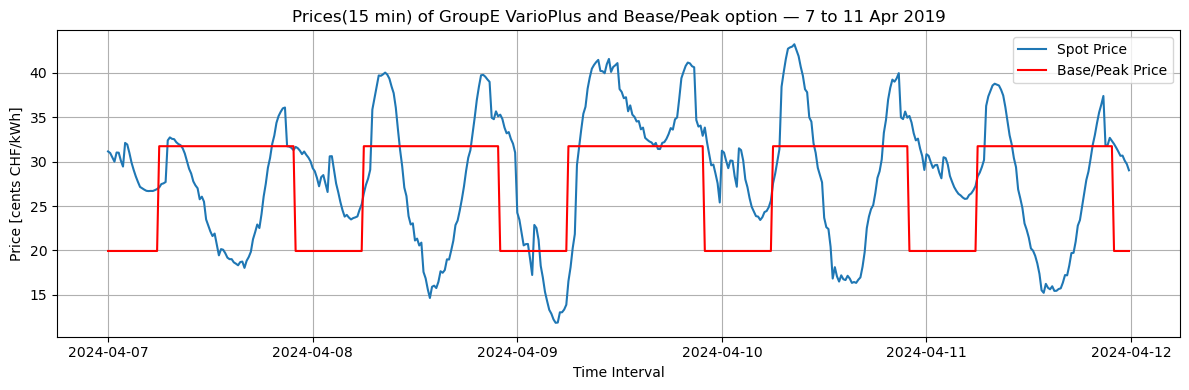

In [82]:
spot_prices = pd.read_csv('VarioPlus_2019-04-07_to_2019-04-11_15min.csv',parse_dates=['time'],index_col='time')
base_price = 19.94 #in cents CHF/kWh
peak_price = 31.73 #in cents CHF/kWh

#create an array called Base_Peak_price of the format 2019-04-07 00:00:00,5.901  where price from 6 to 22 is Peak Price and base otherwise 
start = spot_prices.index[0]
rng = pd.date_range(start, periods=horizon, freq='15T')
prices = [ peak_price if 6 <= ts.hour < 22 else base_price for ts in rng ]

Base_Peak_price_df = (pd.DataFrame({'price': prices}, index=rng) ) #dataframe with price for printing correctly
Base_Peak_price = list(zip(rng, prices))#tupple with time and price for the model to ensure smooth operation with edo's modifications
for t, p in Base_Peak_price:
    print(f"{t},{p}")

plt.figure(figsize=(12, 4))
plt.plot(spot_prices.index, spot_prices['price'],label='Spot Price')
plt.plot(Base_Peak_price_df.index, Base_Peak_price_df['price'],  label='Base/Peak Price', color='red')

plt.title('Prices(15 min) of GroupE VarioPlus and Bease/Peak option — 7 to 11 Apr 2019')
plt.xlabel('Time Interval')
plt.ylabel('Price [cents CHF/kWh]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

spot_prices = np.array(spot_prices['price']/100) #conversions from centimes to CHF

In [66]:
print(spot_prices[0:10])

[0.3114 0.3096 0.3048 0.2999 0.3102 0.31   0.3011 0.2944 0.321  0.3192]


### Temperature loading

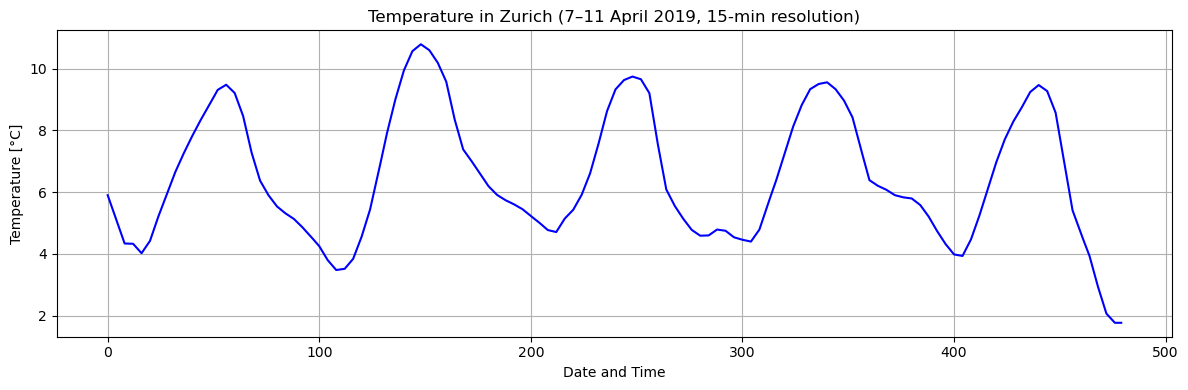

In [67]:
# i import and display Temperature_Data_Zurich_15min.csv
temperature_data = pd.read_csv('Temperature_Data_Zurich_15min.csv', parse_dates=['time'])
# Plot the temperature (°C) at 15-minute intervals
plt.figure(figsize=(12, 4))
plt.plot(temperature_data.index, temperature_data['temperature'], color='blue')
plt.title('Temperature in Zurich (7–11 April 2019, 15-min resolution)')
plt.xlabel('Date and Time')
plt.ylabel('Temperature [°C]')
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
temperature_data.head()

,time,temperature
0,2019-04-07 00:00:00,5.9010
1,2019-04-07 00:15:00,5.7065
2,2019-04-07 00:30:00,5.5120
3,2019-04-07 00:45:00,5.3175
4,2019-04-07 01:00:00,5.1230


### Solar irradiance

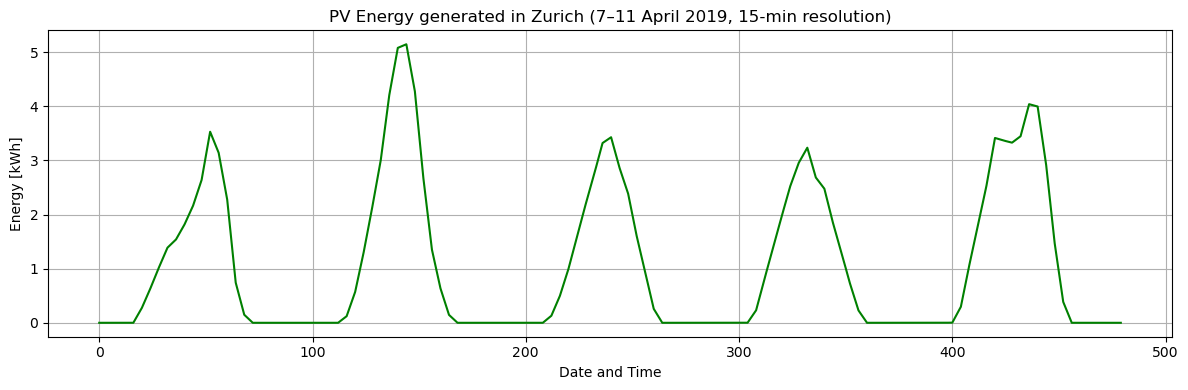

In [69]:
solar_energy = pd.read_csv('Solar_Energy_Zurich_15min.csv') #kWh/m²
PV_area = 200 # m²
PV_efficiency = 0.2 # 20% efficiency
PV_elec = solar_energy['Energy [kWh/m²]'] * PV_area * PV_efficiency # kWh
PV_elec = np.array(PV_elec)

# Plot the solar energy (kWh) at 15-minute intervals
plt.figure(figsize=(12, 4))
plt.plot(solar_energy.index, PV_elec, color='green')
plt.title('PV Energy generated in Zurich (7–11 April 2019, 15-min resolution)')
plt.xlabel('Date and Time')
plt.ylabel('Energy [kWh]')
plt.grid(True)
plt.tight_layout()
plt.show()  


## Modelling 

### EVs:

In [70]:
# --- PARAMETERS ---
n_evs        = 15          # number of EVs
P_rated      = 4.0         # kW, max charger power
E_req        = 6.0         # kWh, daily depleted energy of 6 kWh per EV
dt           = 0.25        # hours per time slot (15 min ⇒ 0.25 h)
T_day        = 96          # total 15-min slots per day
days         = 5           # number of days
start_idx    = 9 * 4       # 9:00 → slot 36
end_idx      = 18 * 4      # 18:00 → slot 72 (exclusive upper bound)
# index sets
evs = range(n_evs) 
slots = range(T_day)
days_ = range(days)

# continuous variable p[e,t] ∈ [0, P_rated] = charging power of EV e in slot t (kW)
p = model.addVars(evs, days, slots, #create set of decision variables, indexed by EVs, time slots and day
            #each variable p[e, t] corresponds to the charging power of EV e during time slot t in kW
            vtype=GRB.CONTINUOUS,
            lb=0.0, # lower bound of the variable
            ub=P_rated, # upper bound of the variable, P_rated is the maximum charging power
            name="p") #base name of the variable

# 1) Energy requirement: each EV must accumulate E_req kWh over the allowed window
for e in evs:
    for d in days_:
        model.addConstr(
            gp.quicksum(p[e,d,t] * dt for t in range(start_idx, end_idx)) == E_req,
            name=f"energy_e{e}_d{d}"
        )

# 2) Enforce zero charging outside [9:00,18:00), each day.
for e in evs:
    for d in days_:
        # before 9:00
        for t in range(0, start_idx):
            model.addConstr(p[e,d,t] == 0,
                        name=f"zero_before_e{e}_d{d}_t{t}")
        # after 18:00
        for t in range(end_idx, T_day):
            model.addConstr(p[e,d,t] == 0,
                        name=f"zero_after_e{e}_d{d}_t{t}")

# (the ub=P_rated on p already enforces p[e,t] ≤ P_rated for all t)

# 3) Total cost of charging: 
total_cost_EV = gp.LinExpr() #important to define the total cost as a gurobi linear expression!

for e in evs:
    for d in days_:
        for t in slots:
            index = d * T_day + t  # flat index into spot_price
            price = spot_prices[index]  # CHF per kWh
            total_cost_EV += p[e, d, t] * price * dt

print("Total cost of EV:")
print(total_cost_EV)

Total cost of EV:
0.07785 <gurobi.Var *Awaiting Model Update*> + 0.0774 <gurobi.Var *Awaiting Model Update*> + 0.0762 <gurobi.Var *Awaiting Model Update*> + 0.074975 <gurobi.Var *Awaiting Model Update*> + 0.07755 <gurobi.Var *Awaiting Model Update*> + 0.0775 <gurobi.Var *Awaiting Model Update*> + 0.075275 <gurobi.Var *Awaiting Model Update*> + 0.0736 <gurobi.Var *Awaiting Model Update*> + 0.08025 <gurobi.Var *Awaiting Model Update*> + 0.07980000000000001 <gurobi.Var *Awaiting Model Update*> + 0.07745 <gurobi.Var *Awaiting Model Update*> + 0.074725 <gurobi.Var *Awaiting Model Update*> + 0.072675 <gurobi.Var *Awaiting Model Update*> + 0.07085 <gurobi.Var *Awaiting Model Update*> + 0.0693 <gurobi.Var *Awaiting Model Update*> + 0.06787499999999999 <gurobi.Var *Awaiting Model Update*> + 0.067475 <gurobi.Var *Awaiting Model Update*> + 0.06709999999999999 <gurobi.Var *Awaiting Model Update*> + 0.066775 <gurobi.Var *Awaiting Model Update*> + 0.0667 <gurobi.Var *Awaiting Model Update*> + 0.0667

### Additive Manufacturing (AM) Machines

In [77]:
# Parameters
n_AMM = 5 # number of AM machines
AMM = range(n_AMM) # index set for AM machines
power_AMM = 2.76  # Power consumption of each printer in kW

# Full cycle of a printer corresponds to 4 hours of operation (or 16 slots of 15 minutes)
D = 16

# Decision variable, x[m,t] = 1 if machine m starts a job at time t
x = model.addVars(n_AMM,horizon,vtype=GRB.BINARY,name='start')

# Prevent overlapping jobs on the same machine: Ensures machine m can't start two jobs too close together
for m in AMM:
    for t1 in range(horizon - D + 1):
        for t2 in range(t1 + 1, min(t1 + D, horizon - D + 1)):
            model.addConstr(x[m, t1] + x[m, t2] <= 1,
                            name=f"no_overlap_m{m}_t{t1}_t{t2}")

# Last feasible time to start

# Every week, 100 pieces must be produced (20 per day)
model.addConstr(
    gp.quicksum(x[m, t] for m in AMM for t in range(horizon - D + 1)) == 100,
    name="min_production"
)

# total cost of the AM machines
cost_AMM = gp.quicksum(x[m, t] * sum(spot_prices[t] for t in range(t,t+D)) * power_AMM * dt for m in AMM for t in range(horizon - D + 1))
#cost_AMM = gp.quicksum(x[m, t] * spot_prices[t] * power_AMM * D* dt for m in AMM for t in range(horizon))

### Heating demand

In [78]:
# --- PARAMETERS FOR THERMAL MODEL ---
COP_h = 2.5               # Heating COP
COP_c = 2.5               # Cooling COP
inertia = 0.98            # Inertia factor ϵ
A_th = 2.0                # Thermal conductivity [kW/°C]
T_desired = 19.0          # Setpoint temperature [°C]
dead_band = 2.0           # ± dead-band [°C]
T_lower = T_desired - dead_band  # Lower comfort limit (17°C)
T_upper = T_desired + dead_band  # Upper comfort limit (21°C)

# Initial indoor temperature (set here at the lower bound, can be modified)
T_0 = T_lower

# Use the outside temperature from your temperature_data; ensure the ordering/matching with time steps.
T_out = temperature_data['temperature'].values

N = horizon               # Total number of intervals 

# Define working hours mask (09:00–18:00); T_set is used only to indicate working hours
mask_work = (temperature_data['time'].dt.hour >= 9) & (temperature_data['time'].dt.hour < 18)
T_set = np.full(horizon, np.nan)
T_set[mask_work.values] = T_desired

# Compute effective heating and cooling coefficients:
alpha_h = (1 - inertia) * (COP_h / A_th)   # Effect of additional heating
alpha_c = (1 - inertia) * (COP_c / A_th)   # Effect of additional cooling

# Decision variables:
# Define p_h for heating power and p_c for cooling power.
# Here, the space heater is sized at 40 kW; you might set a similar bound for cooling.
p_h = model.addVars(horizon-1, lb=0.0, ub=40.0, name="p_heat")
p_c = model.addVars(horizon-1, lb=0.0, ub=40.0, name="p_cool")

# Indoor temperature state variables:
T_in = model.addVars(horizon, lb=-GRB.INFINITY, name="T_in")
model.addConstr(T_in[0] == T_0, name="init_temp")

# Thermal dynamics constraint:
# T_in[k+1] = inertia * T_in[k] + (1 - inertia) * T_out[k] + (alpha_h * p_h[k]) - (alpha_c * p_c[k])
for k in range(N-1):
    model.addConstr(
        T_in[k+1] == inertia * T_in[k] + (1 - inertia) * T_out[k] + alpha_h * p_h[k] - alpha_c * p_c[k],
        name=f"dyn_{k}"
    )

# Comfort constraints (only enforced during working hours):
# Ensure that T_in stays within [T_lower, T_upper] (i.e. within ±2°C of 19°C)
for k in range(N):
    if not np.isnan(T_set[k]):
        model.addConstr(T_in[k] >= T_lower, name=f"min_comfort_{k}")
        model.addConstr(T_in[k] <= T_upper, name=f"max_comfort_{k}")

# Energy consumption of the heating and cooling systems using spot prices
cost_HC = gp.quicksum((p_h[k] + p_c[k]) * dt * spot_prices[k] for k in range(horizon-1))

### Objective function

In [79]:
# Add a constant term to the model objective: models the critical appliances
total_cost_critical = gp.LinExpr() #important to define the total cost as a gurobi linear expression!
for t in range(480):
    total_cost_critical += Critical_Demand[t] * spot_prices[t]

total_cost_week = total_cost_EV + cost_AMM + cost_HC + total_cost_critical 
model.setObjective(total_cost_week, GRB.MINIMIZE)

# Solve the model, i.e. minimize the cost
model.write('out.lp')
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B81)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 218166 rows, 34552 columns and 448758 nonzeros
Model fingerprint: 0x58282f5c
Variable types: 20152 continuous, 14400 integer (14400 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [3e-02, 4e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [4e-02, 1e+02]

MIP start from previous solve produced solution with objective 775.738 (0.41s)
MIP start from previous solve produced solution with objective 775.738 (0.43s)
Loaded MIP start from previous solve with objective 775.738

Presolve removed 185054 rows and 14967 columns
Presolve time: 0.31s
Presolved: 33112 rows, 19585 columns, 208345 nonzeros
Variable types: 5635 continuous, 13950 integer (13950 binary)
Performing another presolve...
Presolve removed 29096 rows and 15679 columns
Presolve time: 

In [80]:
## ENERGY CONSUMPTION CALCULATION BY CATEGORY
total_energy_kWh = 0.0

# EV charging
energy_ev = sum(p[e, d, t].X * dt for e in evs for d in days_ for t in slots)
total_energy_kWh += energy_ev

# AM machines
energy_am = sum(x[m, t].X * power_AMM * D * dt for m in AMM for t in range(horizon - D + 1))
total_energy_kWh += energy_am

# Heating and cooling
energy_heat = sum(p_h[k].X * dt for k in range(horizon - 1))
energy_cool = sum(p_c[k].X * dt for k in range(horizon - 1))
total_energy_kWh += energy_heat + energy_cool

# Critical appliances (already in kWh)
energy_critical = np.sum(Critical_Demand)
total_energy_kWh += energy_critical

# Final output
print(f" Total energy consumed during the week: {total_energy_kWh:.2f} kWh")
print(f"  - EV Charging:     {energy_ev:.2f} kWh")
print(f"  - AM Machines:     {energy_am:.2f} kWh")
print(f"  - Heating:         {energy_heat:.2f} kWh")
print(f"  - Cooling:         {energy_cool:.2f} kWh")
print(f"  - Critical Loads:  {energy_critical:.2f} kWh")

 Total energy consumed during the week: 3166.38 kWh
  - EV Charging:     450.00 kWh
  - AM Machines:     1104.00 kWh
  - Heating:         817.71 kWh
  - Cooling:         0.00 kWh
  - Critical Loads:  794.68 kWh


In [81]:
## PRICE CALCULATION BY CATEGORY
total_cost = model.ObjVal + total_cost_critical.getValue()
check_cost = total_cost_EV.getValue() + cost_AMM.getValue() + cost_HC.getValue() + total_cost_critical.getValue()
print(check_cost) #pour s'assurer que c'est bien egal a la objective function.
# Display
print(" Weekly Cost Breakdown (CHF):")
print(f"  - EV Charging:     CHF {total_cost_EV.getValue():.2f}")
print(f"  - AM Machines:     CHF {cost_AMM.getValue():.2f}")
print(f"  - Heating/Cooling: CHF {cost_HC.getValue():.2f}")
print(f"  - Critical Loads:  CHF {total_cost_critical.getValue():.2f}")
print(f"  -----------------------------")
print(f"  Total Costs from Objective function: CHF {model.ObjVal:.2f}")

775.7377313672735
 Weekly Cost Breakdown (CHF):
  - EV Charging:     CHF 88.26
  - AM Machines:     CHF 272.35
  - Heating/Cooling: CHF 189.59
  - Critical Loads:  CHF 225.53
  -----------------------------
  Total Costs from Objective function: CHF 775.74


In [45]:
# Access EV charging schedule
ev_power_schedule = np.zeros((n_evs, days, T_day))
for e in evs:
    for d in days_:
        for t in slots:
            ev_power_schedule[e, d, t] = p[e, d, t].X #.X is used to access the value of the variable after optimization

# Access AM machine start schedule
am_schedule = np.zeros((n_AMM, horizon))
for m in AMM:
    for t in range(horizon):
        am_schedule[m, t] = x[m, t].X

# Access heating and cooling power
p_heat = np.array([p_h[k].X for k in range(horizon - 1)])
p_cool = np.array([p_c[k].X for k in range(horizon - 1)])

# Indoor temperature trajectory
T_indoor = np.array([T_in[k].X for k in range(horizon)])

22553.0762495
Objective value: 53192.85 CHF


/var/folders/0w/44rywk3j1dl_gqy839v3wqyh0000gn/T/ipykernel_32863/395698962.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


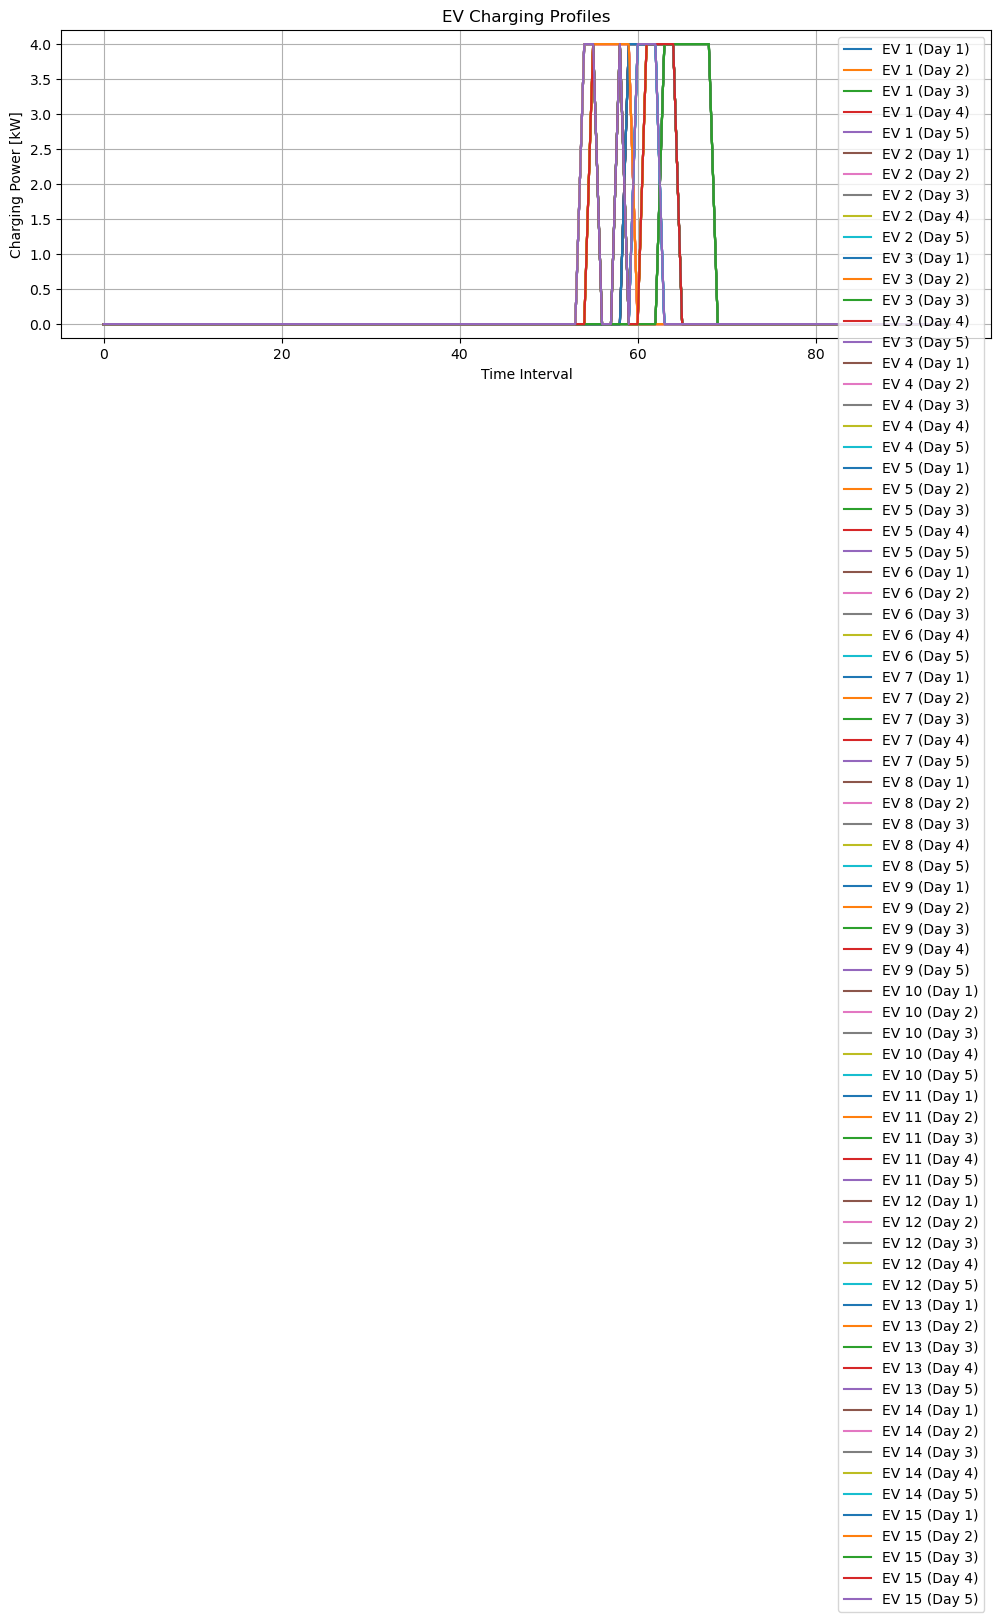

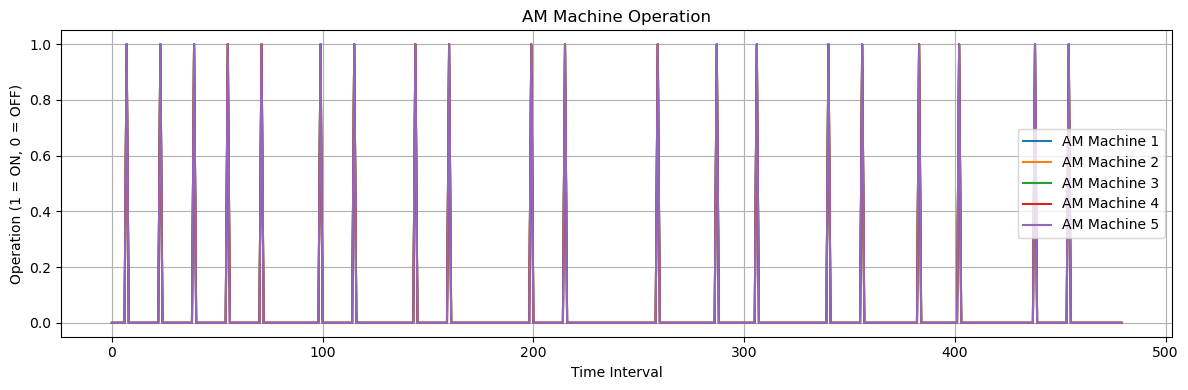

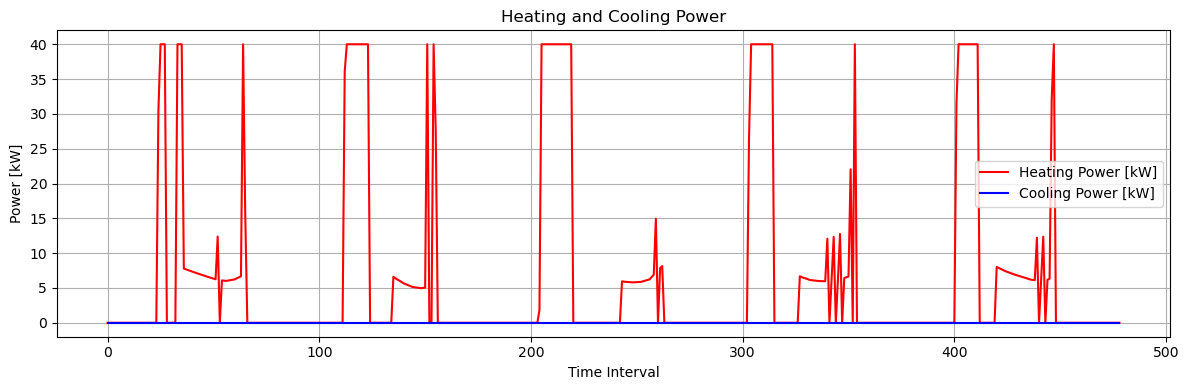

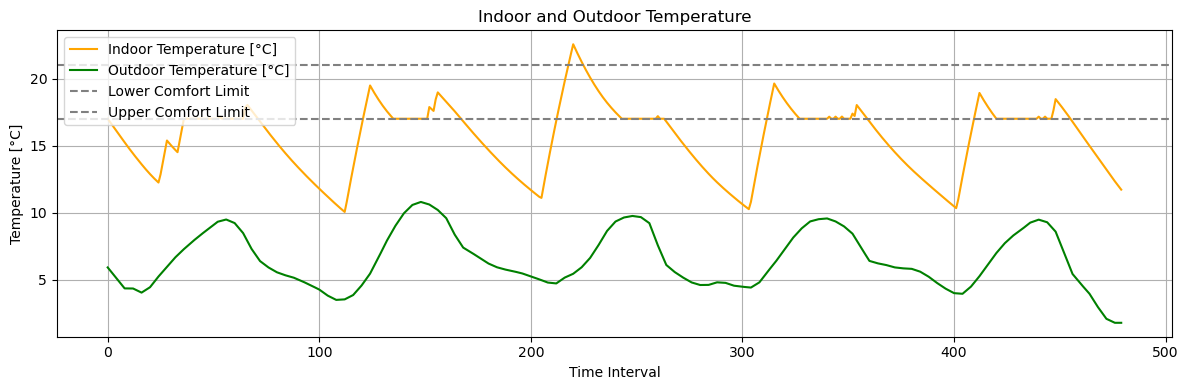

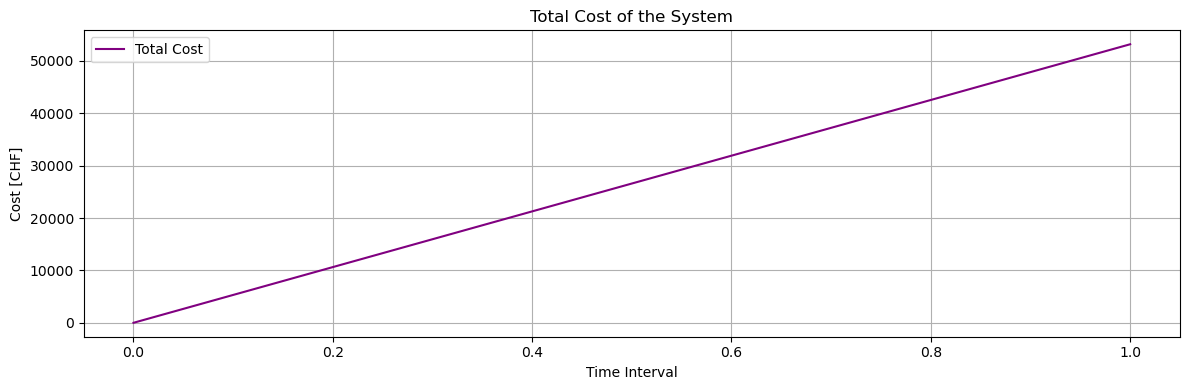

In [46]:
print(total_cost_critical)
# --- POST-PROCESSING ---
# Extract the values of the decision variables
print(f"Objective value: {model.objVal:.2f} CHF")
# Extract the values of the decision variables
p_values = np.zeros((n_evs, days, T_day))
for e in evs:
    for d in days_:
        for t in slots:
            p_values[e, d, t] = p[e, d, t].X
x_values = np.zeros((n_AMM, horizon))
for m in AMM:
    for t in range(horizon):
        x_values[m, t] = x[m, t].X
p_h_values = np.zeros(horizon-1)
for k in range(horizon-1):
    p_h_values[k] = p_h[k].X
p_c_values = np.zeros(horizon-1)
for k in range(horizon-1):
    p_c_values[k] = p_c[k].X
T_in_values = np.zeros(horizon)
for k in range(horizon):
    T_in_values[k] = T_in[k].X
T_out_values = np.zeros(horizon)
for k in range(horizon):
    T_out_values[k] = T_out[k]
# Plot the results
# Plot the EV charging profiles
plt.figure(figsize=(12, 4))
for e in evs:
    for d in days_:
        plt.plot(p_values[e, d, :], label=f"EV {e+1} (Day {d+1})")
plt.title('EV Charging Profiles')
plt.xlabel('Time Interval')
plt.ylabel('Charging Power [kW]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Plot the AM machine operation
plt.figure(figsize=(12, 4))
for m in AMM:
    plt.plot(x_values[m, :], label=f"AM Machine {m+1}")
plt.title('AM Machine Operation')
plt.xlabel('Time Interval')
plt.ylabel('Operation (1 = ON, 0 = OFF)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Plot the heating and cooling power
plt.figure(figsize=(12, 4))
plt.plot(p_h_values, label='Heating Power [kW]', color='red')
plt.plot(p_c_values, label='Cooling Power [kW]', color='blue')
plt.title('Heating and Cooling Power')
plt.xlabel('Time Interval')
plt.ylabel('Power [kW]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Plot the indoor temperature
plt.figure(figsize=(12, 4))
plt.plot(T_in_values, label='Indoor Temperature [°C]', color='orange')
plt.plot(T_out_values, label='Outdoor Temperature [°C]', color='green')
plt.axhline(y=T_lower, color='gray', linestyle='--', label='Lower Comfort Limit')
plt.axhline(y=T_upper, color='gray', linestyle='--', label='Upper Comfort Limit')
plt.title('Indoor and Outdoor Temperature')
plt.xlabel('Time Interval')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Plot the total cost
plt.figure(figsize=(12, 4))
plt.plot([0, 1], [0, model.objVal], label='Total Cost', color='purple')
plt.title('Total Cost of the System')
plt.xlabel('Time Interval')
plt.ylabel('Cost [CHF]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

